# Spatiotemporal CNN-RNN Proxy Model for CO2 Monitoring
### Misael M. Morales, 2023
***

In [1]:
from utils import *
check_tensorflow_gpu()

proxy = SpatiotemporalCO2()
#proxy.__dict__

... Checking Tensorflow Version ...
Tensorflow built with CUDA? True
TF: 2.10.0 | CUDA: 64_112 | cuDNN: 64_8
# GPU available: 1 (Quadro M6000 24GB, pci )


In [2]:
proxy.load_data()
proxy.process_data()

... Loading Full Dataset ...
X: (1000, 64, 64, 4) | y: (1000, 60, 64, 64, 2)
Data Augmentation Done!    - n_samples=2,000
MinMax Normalization Done! - [0.0, 1.0]
Train - X: (1500, 64, 64, 4) | y: (1500, 11, 64, 64, 2)
Test  - X: (500, 64, 64, 4)  | y: (500, 11, 64, 64, 2)


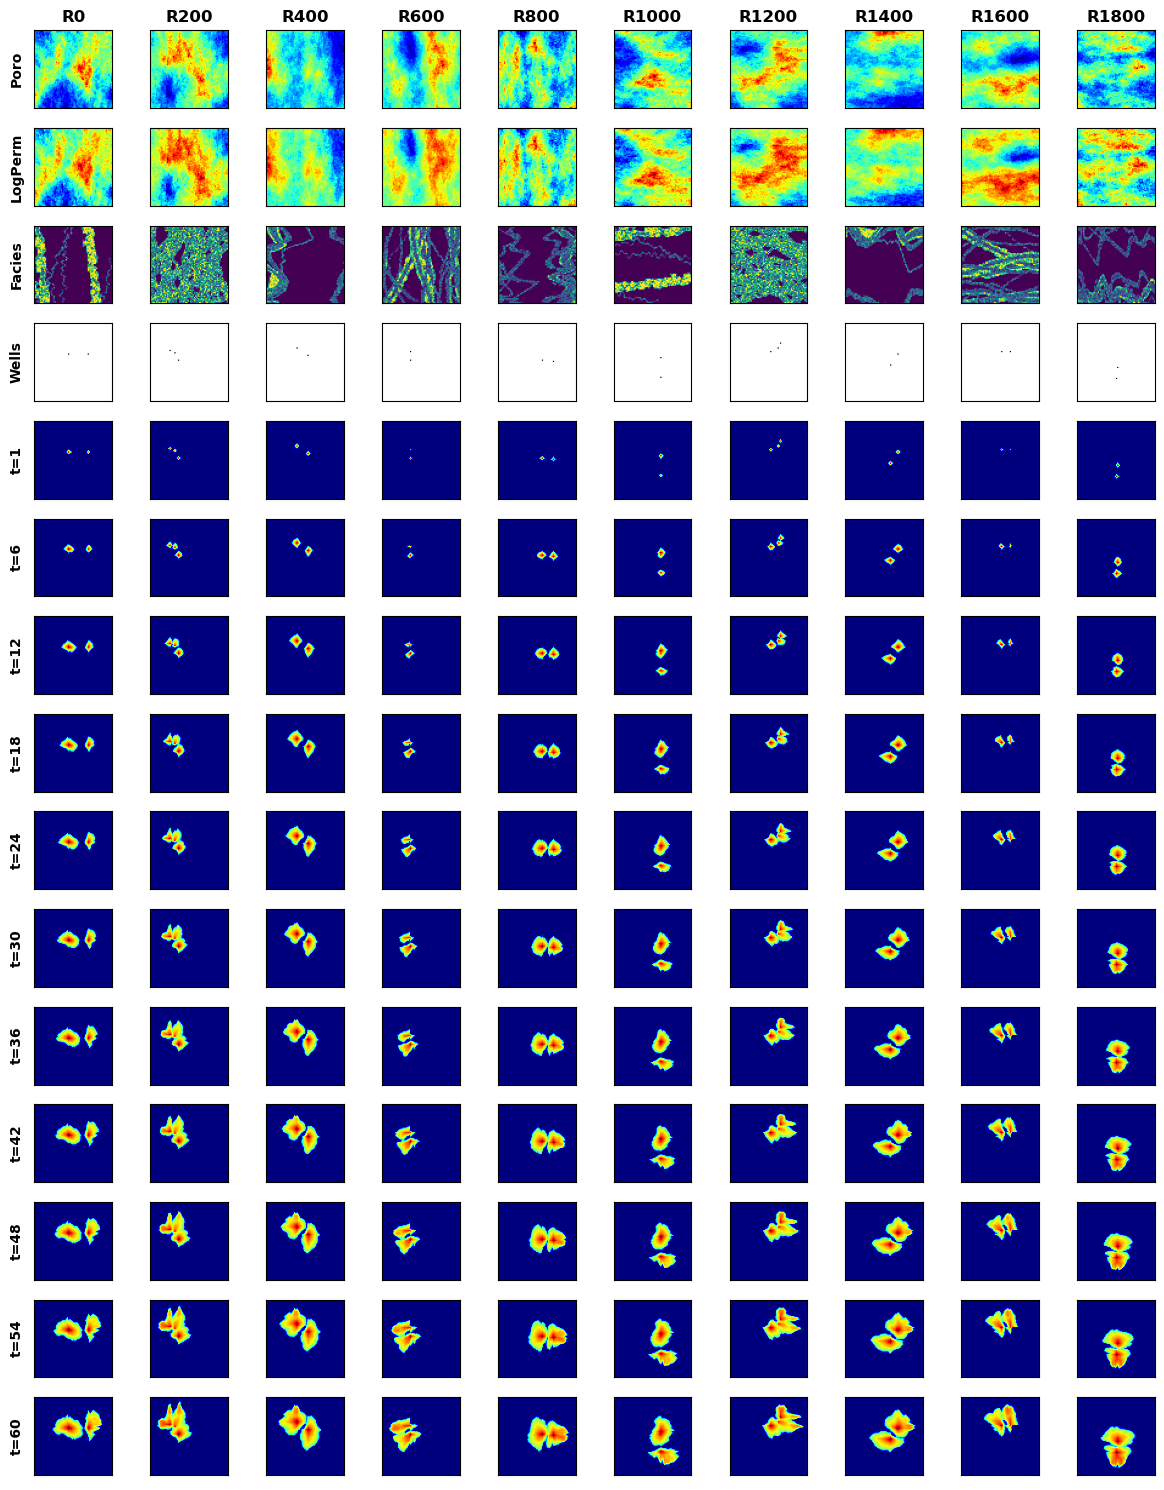

In [3]:
proxy.plot_data()
#proxy.plot_features(); proxy.plot_targets()

In [4]:
proxy.make_model()
#proxy.model.summary()

In [5]:
proxy.training()

# Parameters: 65,160,306 | Batch size: 50 
Epoch: [10/100] - Loss: 0.1634 - Val Loss: 0.2253
Epoch: [20/100] - Loss: 0.1224 - Val Loss: 0.1453
Epoch: [30/100] - Loss: 0.1031 - Val Loss: 0.1012
Epoch: [40/100] - Loss: 0.0913 - Val Loss: 0.0857
Epoch: [50/100] - Loss: 0.0851 - Val Loss: 0.0805
Epoch: [60/100] - Loss: 0.0819 - Val Loss: 0.0963
Epoch: [70/100] - Loss: 0.0776 - Val Loss: 0.0863


In [ ]:
proxy.predictions()

In [ ]:
proxy.latent_space()
#proxy.feature_map_animation

In [ ]:
proxy.plot_single_results(42, 'train')

In [ ]:
proxy.cumulative_co2()

***
# END